# Prepare atmosphre.csv
(see spreadsheet from John Beale)

Requires Precipitation, PET and LAI. LAI is used to separate PE and PT.

LAI from MODIS. Precip and PET could be from:
- COSMOS-UK site 
- CHESSmet and CHESS PE
- ERA5

Note:
- COSMOS PE (COSMOS-UK_ALIC1_HydroSoil_Daily_2013-2019.csv )

In [3]:
import pandas as pd
import datetime as dt
import numpy as np

/tmp/ipykernel_2605/1387834191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MODIS['CALC'][0] = MODIS['LAI'][0] # this gives a warning
/tmp/ipykernel_2605/1387834191.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MODIS['Date0'][0] = MODIS['Date2'][0] # this gives a warning
/tmp/ipykernel_2605/1387834191.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MODIS['LAI_pred'][0] = MODIS['LAI'][0]


,LAI_pred
2018-01-01,1.100000
2018-01-02,1.125000
2018-01-03,1.150000
2018-01-04,1.175000
2018-01-05,1.200000
...,...
2018-12-27,0.933333
2018-12-28,0.725000
2018-12-29,0.683333
2018-12-30,0.641667


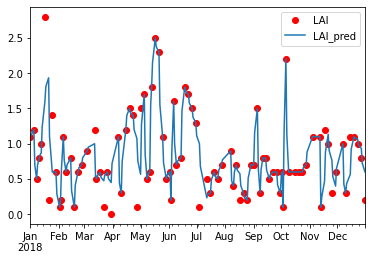

In [6]:
MODIS = pd.read_csv('data/MODIS_LAI_2015-12-15_to_2023-03-03.csv',parse_dates=['Date'])
site = 'ROTHD'
MODIS = MODIS.loc[MODIS['SITE_ID']==site] \
        .loc[MODIS['Date'].dt.year ==2018]  \
        .sort_values('Date').reset_index(drop=True)
#MODIS.plot(x='Date',y='LAI', style='ro')
MODIS['CALC'] = MODIS['LAI'].shift(1) + (MODIS['LAI']-MODIS['LAI'].shift(1))/(MODIS['Confidence']+1)
MODIS['CALC'][0] = MODIS['LAI'][0] # this gives a warning
MODIS['CALC2'] = MODIS['CALC']
MODIS['Date2'] = MODIS['Date']
MODIS['Date0'] = MODIS['Date2'].shift(1)
MODIS['Date0'][0] = MODIS['Date2'][0] # this gives a warning

########## padding missing dates #################
idx = pd.date_range(start='1/1/2018', end='31/12/2018') 
MODIS = MODIS.set_index(['Date'])#.drop(columns='SITE_ID')
MODIS = MODIS.reindex(idx)

MODIS['SITE_ID'].ffill(inplace=True)
MODIS['CALC'].ffill(inplace=True)
MODIS['Date2'].bfill(inplace=True) # just for the first entries
MODIS['CALC2'].bfill(inplace=True) 
MODIS['Date0'].ffill(inplace=True) # just for the first entries

# ifelse(~nan(Conf), CALC, CALC-1)


# now do traingle rule between CALC and CALC2
MODIS['LAI_pred'] = MODIS['CALC2'] + (MODIS['CALC']-MODIS['CALC2']) *((MODIS['Date2']-MODIS.index)/ np.timedelta64(1, 'D')).astype(int)/ \
                        ((MODIS['Date2']-MODIS['Date0'])/ np.timedelta64(1, 'D')).astype(int)
MODIS['LAI_pred'][0] = MODIS['LAI'][0] 

MODIS[['LAI','LAI_pred']].plot(style=['ro','-'])
MODIS

### Look up VWC and PE from COSMOS daily file

,Date,PE
1256,2018-01-01,0.5
1257,2018-01-02,0.2
1258,2018-01-03,1.3
1259,2018-01-04,0.6
1260,2018-01-05,0.5
...,...,...
1616,2018-12-27,0.2
1617,2018-12-28,0.2
1618,2018-12-29,0.2
1619,2018-12-30,0.1


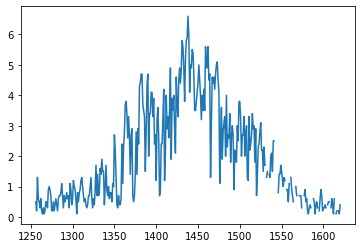

In [387]:
cosmos_vwc = pd.read_csv('/data/moisturedata/COSMOS-UK_HydroSoil_Daily/COSMOS-UK_'+site+'_HydroSoil_Daily_2013-2019.csv', na_values=-9999).rename(columns={'DATE_TIME':'Date'})
cosmos_vwc["Date"] = pd.to_datetime(cosmos_vwc["Date"])

PE = cosmos_vwc[['Date','PE']].loc[(cosmos_vwc['Date'].dt.year ==2018)]
cosmos_vwc = cosmos_vwc[['Date','COSMOS_VWC']].loc[(cosmos_vwc['Date'].dt.year ==2018)]
PE['PE'].plot()
PE

### Aggregate rainfall from COSMOS hourly file

In [388]:
precip_cosmos = pd.read_csv('/data/moisturedata/COSMOS-UK_HydroSoil_SH_2013-2019/COSMOS-UK_'+site+'_HydroSoil_SH_2013-2019.csv', na_values=-9999)
precip_cosmos = precip_cosmos[['PRECIP']].groupby(pd.to_datetime(precip_cosmos.DATE_TIME).dt.date).PRECIP.agg(['sum','count']).reset_index() \
        .rename(columns={'DATE_TIME':'Date','sum':'PRECIP'})
precip_cosmos["Date"] = pd.to_datetime(precip_cosmos["Date"])

precip_cosmos = precip_cosmos.loc[(precip_cosmos['Date'].dt.year ==2018)]
#precip_cosmos.loc[(precip_cosmos['Date'].dt.year ==2018) & (precip_cosmos['count'] < 48)] # checking missing data

In [389]:
precip_cosmos

,Date,PRECIP,count
1256,2018-01-01,0.83,48
1257,2018-01-02,8.33,48
1258,2018-01-03,0.15,48
1259,2018-01-04,6.69,48
1260,2018-01-05,0.27,48
...,...,...,...
1616,2018-12-27,0.00,48
1617,2018-12-28,0.00,48
1618,2018-12-29,0.00,48
1619,2018-12-30,0.05,48


# write to atmosphere.csv

In [390]:
atmo = PE.set_index('Date').join(precip_cosmos.set_index('Date')).join(MODIS['LAI_pred']) \
    .assign(rSoil=lambda x: (x['PE']*np.exp(-0.463*x['LAI_pred']) )) \
    .assign(rRoot=lambda x: (x['PE']-x["rSoil"])) \
    .drop(columns=['count','LAI_pred','PE']) \
    .transform(lambda x: x * 0.1) \
    .assign(hCritA=lambda x: 100000) \
    .assign(tAtm=lambda x: range(len(x))).set_index('tAtm')\
    .rename(columns={"PRECIP":"Prec"}).reset_index()\
    .assign(tAtm=lambda x: x['tAtm']+1) 


atmo.to_csv('data/atmosphere.csv', float_format='%6.4f') # will stuck if too many digits

atmo
# convert mm/day to cm/day


,tAtm,Prec,rSoil,rRoot,hCritA
0,1,0.083,0.030046,0.019954,100000
1,2,0.833,0.011880,0.008120,100000
2,3,0.015,0.076331,0.053669,100000
3,4,0.669,0.034824,0.025176,100000
4,5,0.027,0.028686,0.021314,100000
...,...,...,...,...,...
360,361,0.000,0.012982,0.007018,100000
361,362,0.000,0.014297,0.005703,100000
362,363,0.000,0.014576,0.005424,100000
363,364,0.005,0.007430,0.002570,100000


<AxesSubplot:>

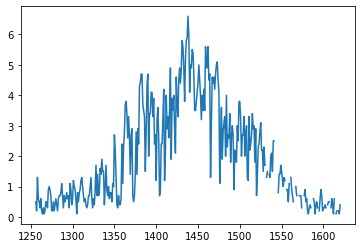

In [391]:
PE['PE'].plot()

# making the tool

In [392]:
%%bash
mkdir -p sm_utils  # Create the folder for the module (on mac or linux)

In [2]:
%%writefile sm_utils/sm_utils.py
import numpy as np
import pandas as pd
from datetime import datetime
import io
import json
import requests
import zipfile

class CosmosData:
    """
    A simple class to extract data for COSMOS-UK site.

    Parameters
    ----------
    years: vector of years in integers
    site: COSMOS-UK site code to extract data

    Examples
    --------

    >>> CosmosData(years=[2018,2019],site='CHIMN')

    """
    def __init__(self, years, site, method='api'):
        self.years = years
        self.site = site
        #self.driving_data = pd.DataFrame()
        
        # order is important!
        self.cosmos_data =  self.get_cosmos_data()
        self.PE_data =  self.get_PE_data()
        self.PREC_data =  self.get_PREC_data()
        self.MODIS_data =  self.get_MODIS_data()
        self.LAI_data =  self.get_LAI_data()
        self.driving_data =  pd.concat([self.PE_data,self.PREC_data,self.LAI_data], axis=1)
        self.api_data = self.get_cosmos_api_data()
        
        self.driving_data =  pd.concat([self.get_cosmos_api_single('pe'),self.get_cosmos_api_single('precip'),self.LAI_data], axis=1)
        self.atmo_data = self.write_atmo_data()

        
#     def __str__(self):
#         return f"{self.site}"

    def get_cosmos_api_data(self):
        
        def format_datetime(dt):
            return dt.strftime("%Y-%m-%dT%H:%M:%SZ")
        
        def get_api_response(url, csv=False):
            """ Helper function to send request to API and get the response 

            :param str url: The URL of the API request
            :param bool csv: Whether this is a CSV request. Default False. 
            :return: API response
            """ 
            # Send request and read response
            print(url)
            response = requests.get(url)

            if csv:
                return response
            else:
                # Decode from JSON to Python dictionary
                return json.loads(response.content)
        
        def read_json_collection_data(json_response):
            """ Wrangle the response JSON from a COSMOS-API data collection request into a more usable format - in this case a Pandas Dataframe

            :param dict json_response: The JSON response dictionary returned from a COSMOS-API data collection request
            :return: Dataframe of data
            :rtype: pd.DataFrame
            """
            # The response is a list of dictionaries, one for each requested site

            # You can choose how you want to build your dataframes.  Here, I'm just loading all stations into one big dataframe.  
            # But you could modify this for your own use cases.  For example you might want to build a dictionary of {site_id: dataframe} 
            # to keep site data separate, etc.
            master_df = pd.DataFrame()

            for site_data in resp['coverages']:
                # Read the site ID
                site_id = site_data['dct:identifier']

                # Read the time stamps of each data point
                time_values = pd.DatetimeIndex(site_data['domain']['axes']['t']['values'])

                # Now read the values for each requested parameter at each of the time stamps
                param_values = {param_name: param_data['values'] for param_name, param_data in site_data['ranges'].items()}

                # And put everything into a dataframe
                site_df = pd.DataFrame.from_dict(param_values)
                site_df['datetime'] = time_values
                site_df['site_id'] = site_id

                site_df = site_df.set_index(['datetime', 'site_id']) 
                master_df = pd.concat([master_df, site_df])

            return master_df

        
        
        BASE_URL = 'https://cosmos-api.ceh.ac.uk'


        start_date = format_datetime(datetime(min(self.years), 1, 1))
        end_date = format_datetime(datetime(max(self.years), 12, 31))
        query_date_range = f'{start_date}/{end_date}'
                    
            
        # loop through sites and concat
        df = []
        #for site_id_ii in self.site:
        site_id_ii = self.site
        #loop
        query_url = f'{BASE_URL}/collections/1D/locations/{site_id_ii}?datetime={query_date_range}'
        resp = get_api_response(query_url)
        #print(resp)
        df.append(read_json_collection_data(resp))
            
        df = pd.concat(df)
        return df
    
    def get_cosmos_api_single(self,column):
        return self.api_data[[column]].droplevel('site_id')\
                .reset_index()\
                .assign(date = lambda x: pd.to_datetime(x.datetime).dt.date)\
                .set_index('date')\
                .drop(columns=['datetime'])
    
    def get_cosmos_data(self):
        cosmos_vwc = pd.read_csv('/data/moisturedata/COSMOS-UK_HydroSoil_Daily/COSMOS-UK_'+self.site+'_HydroSoil_Daily_2013-2019.csv', na_values=-9999)\
            .rename(columns={'DATE_TIME':'Date'})
        cosmos_vwc["Date"] = pd.to_datetime(cosmos_vwc["Date"])
        return cosmos_vwc[['Date','COSMOS_VWC']].loc[(cosmos_vwc['Date'].dt.year.isin(self.years))].set_index('Date')

    def get_PE_data(self):
        cosmos_vwc = pd.read_csv('/data/moisturedata/COSMOS-UK_HydroSoil_Daily/COSMOS-UK_'+self.site+'_HydroSoil_Daily_2013-2019.csv', na_values=-9999)\
            .rename(columns={'DATE_TIME':'Date'})
        cosmos_vwc["Date"] = pd.to_datetime(cosmos_vwc["Date"])
        return  cosmos_vwc[['Date','PE']].loc[(cosmos_vwc['Date'].dt.year.isin(self.years))].set_index('Date')
    
    def get_PREC_data(self):
        precip_cosmos = pd.read_csv('/data/moisturedata/COSMOS-UK_HydroSoil_SH_2013-2019/COSMOS-UK_'+self.site+'_HydroSoil_SH_2013-2019.csv', na_values=-9999)
        precip_cosmos = precip_cosmos[['PRECIP']].groupby(pd.to_datetime(precip_cosmos.DATE_TIME).dt.date).PRECIP.agg(['sum','count']).reset_index() \
            .rename(columns={'DATE_TIME':'Date','sum':'PRECIP','count':'prec_count'})
        precip_cosmos["Date"] = pd.to_datetime(precip_cosmos["Date"])
        return precip_cosmos.loc[(precip_cosmos['Date'].dt.year.isin(self.years))].set_index('Date')
    
    def get_LAI_data(self):
        print('LAI')
        return self.get_MODIS_data()

    def get_MODIS_data(self):
        MODIS = pd.read_csv('data/MODIS_LAI_2015-12-15_to_2023-03-03.csv',parse_dates=['Date'])
        MODIS = MODIS.loc[MODIS['SITE_ID']==self.site] \
                .loc[MODIS['Date'].dt.year.isin(self.years)]  \
                .sort_values('Date').reset_index(drop=True)
        #MODIS.plot(x='Date',y='LAI', style='ro')
        MODIS['CALC'] = MODIS['LAI'].shift(1) + (MODIS['LAI']-MODIS['LAI'].shift(1))/(MODIS['Confidence']+1)
        MODIS['CALC'][0] = MODIS['LAI'][0] # this gives a warning
        MODIS['CALC2'] = MODIS['CALC']
        MODIS['Date2'] = MODIS['Date']
        MODIS['Date0'] = MODIS['Date2'].shift(1)
        MODIS['Date0'][0] = MODIS['Date2'][0] # this gives a warning

        ########## padding missing dates #################
        idx = pd.date_range(start='1/1/'+str(min(self.years)), end='31/12/'+str(max(self.years))) 
        MODIS = MODIS.set_index(['Date'])#.drop(columns='SITE_ID')
        MODIS = MODIS.reindex(idx)

        MODIS['SITE_ID'].ffill(inplace=True)
        MODIS['CALC'].ffill(inplace=True)
        MODIS['Date2'].bfill(inplace=True) # just for the first entries
        MODIS['CALC2'].bfill(inplace=True) 
        MODIS['Date0'].ffill(inplace=True) # just for the first entries

        # ifelse(~nan(Conf), CALC, CALC-1)
        # now do traingle rule between CALC and CALC2
        MODIS['LAI_pred'] = MODIS['CALC2'] + (MODIS['CALC']-MODIS['CALC2']) *((MODIS['Date2']-MODIS.index)/ np.timedelta64(1, 'D')).astype(int)/ \
                                ((MODIS['Date2']-MODIS['Date0'])/ np.timedelta64(1, 'D')).astype(int)
        MODIS['LAI_pred'][0] = MODIS['LAI'][0] 
        return MODIS[['LAI_pred']]
    
 #   def get_driving_data(self):
 #       self.driving_data = pd.concat([self.PE_data(),self.PREC_data(),self.LAI_data()], axis=1)
 #       return #pd.concat([self.PE_data(),self.PREC_data(),self.LAI_data()], axis=1)
    
    def write_atmo_data(self):
        """
        Method to write driving data input file for Hydrus (atmosphere.csv).

        Parameters
        ----------

        Returns
        -------
        atmo: dataframe that contains data for atmosphere.csv

        """
        ########## API ######
        atmo = self.get_cosmos_api_single('pe').join(self.get_cosmos_api_single('precip')).join(self.MODIS_data) \
            .assign(rSoil=lambda x: (x['pe']*np.exp(-0.463*x['LAI_pred']) )) \
            .assign(rRoot=lambda x: (x['pe']-x["rSoil"])) \
            .drop(columns=['LAI_pred','pe']) \
            .transform(lambda x: x * 0.1) \
            .assign(hCritA=lambda x: 100000) \
            .assign(tAtm=lambda x: range(len(x))).set_index('tAtm')\
            .rename(columns={"precip":"Prec"}).reset_index()\
            .assign(tAtm=lambda x: x['tAtm']+1) 
        
        print('printing atmo API data.')
        atmo.to_csv('data/atmosphere_API.csv', float_format='%6.4f') # will stuck if too many digits
        
        ########## files ######
        atmo = self.PE_data.join(self.PREC_data).join(self.MODIS_data) \
            .assign(rSoil=lambda x: (x['PE']*np.exp(-0.463*x['LAI_pred']) )) \
            .assign(rRoot=lambda x: (x['PE']-x["rSoil"])) \
            .drop(columns=['LAI_pred','PE']) \
            .transform(lambda x: x * 0.1) \
            .assign(hCritA=lambda x: 100000) \
            .assign(tAtm=lambda x: range(len(x))).set_index('tAtm')\
            .rename(columns={"PRECIP":"Prec"}).reset_index()\
            .assign(tAtm=lambda x: x['tAtm']+1) 
        
        print('printing atmo data.')
        atmo.to_csv('data/atmosphere.csv', float_format='%6.4f') # will stuck if too many digits
        
        return atmo
    
  



Overwriting sm_utils/sm_utils.py


In [3]:
%%writefile sm_utils/__init__.py
from .sm_utils import CosmosData

Overwriting sm_utils/__init__.py


In [1]:
from sm_utils import CosmosData
a = CosmosData(years=[2016,2017,2018,2019],site='CHIMN')
#a.get_cosmos_api_data()[['albedo','cosmos_vwc','precip']]

/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS/sm_utils/sm_utils.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MODIS['CALC'][0] = MODIS['LAI'][0] # this gives a warning
/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS/sm_utils/sm_utils.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MODIS['Date0'][0] = MODIS['Date2'][0] # this gives a warning
/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS/sm_utils/sm_utils.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


LAI
https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z
printing atmo API data.
printing atmo data.


/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/missing.py:483: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return lib.array_equivalent_object(


In [1]:
from sm_utils import CosmosData
a = CosmosData(years=[2016,2017,2018,2019],site='CHIMN')
a

/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS/sm_utils/sm_utils.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MODIS['CALC'][0] = MODIS['LAI'][0] # this gives a warning
/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS/sm_utils/sm_utils.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MODIS['Date0'][0] = MODIS['Date2'][0] # this gives a warning
/data/notebooks/jupyterlab-integration/temp/phydrus/examples/phydrus_paper/COSMOS/sm_utils/sm_utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


LAI
printing atmo data.
https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z


In [2]:
#a.get_driving_data()
a.driving_data

,PE,PRECIP,prec_count,LAI_pred
2016-01-01,0.5,0.74,48,0.600000
2016-01-02,0.3,3.13,48,0.350000
2016-01-03,0.5,8.38,48,0.100000
2016-01-04,0.7,1.08,48,0.100000
2016-01-05,0.3,0.70,48,0.100000
...,...,...,...,...
2019-12-27,0.1,0.00,48,0.933333
2019-12-28,0.2,0.00,48,1.100000
2019-12-29,0.2,0.00,48,1.133333
2019-12-30,0.4,0.00,48,1.166667


In [3]:
a.LAI_data()

TypeError: 'DataFrame' object is not callable

In [4]:
a.driving_data()

TypeError: 'DataFrame' object is not callable

<AxesSubplot:xlabel='Date'>

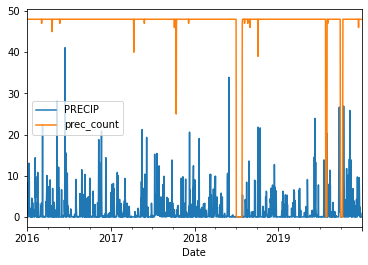

In [5]:
a.PREC_data.plot()

In [6]:
df = a.get_cosmos_api_data()
df[[col for col in df if col.startswith('precip')]]

https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z


,,precip,precip_flag,precip_raine,precip_raine_flag,precip_tipping,precip_tipping_flag
datetime,site_id,,,,,,
2016-01-01 00:00:00+00:00,CHIMN,1.1,None,None,M,None,M
2016-01-02 00:00:00+00:00,CHIMN,3.8,None,None,M,None,M
2016-01-03 00:00:00+00:00,CHIMN,7.4,None,None,M,None,M
2016-01-04 00:00:00+00:00,CHIMN,1.1,None,None,M,None,M
2016-01-05 00:00:00+00:00,CHIMN,0.7,None,None,M,None,M
...,...,...,...,...,...,...,...
2019-12-27 00:00:00+00:00,CHIMN,0.0,None,None,M,None,M
2019-12-28 00:00:00+00:00,CHIMN,0.0,None,None,M,None,M
2019-12-29 00:00:00+00:00,CHIMN,0.0,None,None,M,None,M


https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z
https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z
https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z


Text(0, 0.5, 'COSMOS-UK data API')

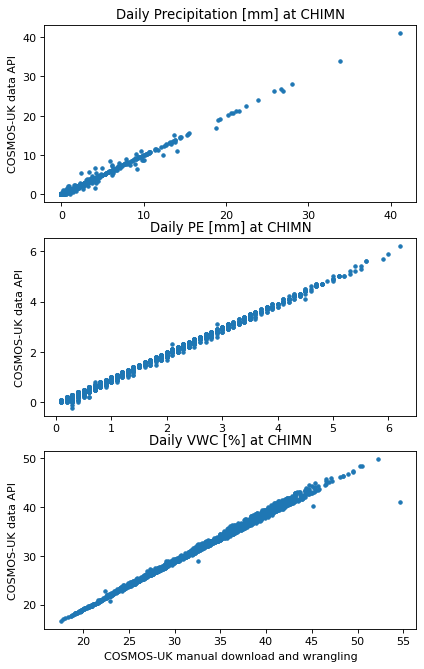

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 10), dpi=80)

plt.subplot(311)
plt.scatter(a.PREC_data[['PRECIP']],a.get_cosmos_api_data()[['precip']],marker='.')
plt.title('Daily Precipitation [mm] at CHIMN')
#plt.xlabel('COSMOS-UK manual download and wrangling')
plt.ylabel('COSMOS-UK data API')

plt.subplot(312)

plt.scatter(a.PE_data,a.get_cosmos_api_data()[['pe']],marker='.')
plt.title('Daily PE [mm] at CHIMN')
#plt.xlabel('COSMOS-UK manual download and wrangling')
plt.ylabel('COSMOS-UK data API')

plt.subplot(313)

plt.scatter(a.cosmos_data,a.get_cosmos_api_data()[['cosmos_vwc']],marker='.')
plt.title('Daily VWC [%] at CHIMN')
plt.xlabel('COSMOS-UK manual download and wrangling')
plt.ylabel('COSMOS-UK data API')

In [18]:
a.get_cosmos_api_data()[['precip']]
a.PREC_data[['PRECIP']]

https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z


,PRECIP
Date,
2016-01-01,0.74
2016-01-02,3.13
2016-01-03,8.38
2016-01-04,1.08
2016-01-05,0.70
...,...
2019-12-27,0.00
2019-12-28,0.00
2019-12-29,0.00


In [63]:
b = a.get_cosmos_api_data()[['precip']].droplevel('site_id')
b.index.to_pydatetime().date()

https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z


AttributeError: 'numpy.ndarray' object has no attribute 'date'

In [77]:
import pandas as pd

a.get_cosmos_api_data()[['precip']].droplevel('site_id')\
    .reset_index()\
    .assign(date = lambda x: pd.to_datetime(x.datetime).dt.date)\
    .set_index('date')\
    .drop(columns=['datetime'])


https://cosmos-api.ceh.ac.uk/collections/1D/locations/CHIMN?datetime=2016-01-01T00:00:00Z/2019-12-31T00:00:00Z


,precip
date,
2016-01-01,1.1
2016-01-02,3.8
2016-01-03,7.4
2016-01-04,1.1
2016-01-05,0.7
...,...
2019-12-27,0.0
2019-12-28,0.0
2019-12-29,0.0


In [8]:
a.PE_data.loc[a.PE_data.PE<0.2]

,PE
Date,
2016-12-06,0.1
2016-12-10,0.1
2016-12-15,0.1
2017-01-16,0.1
2017-01-31,0.1
2017-12-20,0.1
2018-11-16,0.1
2018-11-27,0.1
2018-12-05,0.1


<AxesSubplot:>

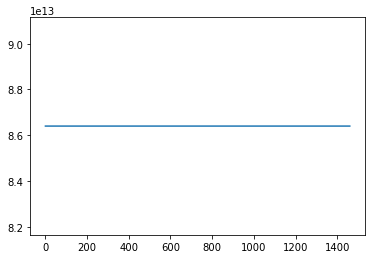

In [24]:
a.PE_data.reset_index().Date.diff().plot()